In [1]:
import cvxopt
print(cvxopt.__version__)

1.3.0


In [2]:
import sys
print(sys.executable)

C:\Program Files\Python311\python.exe


In [3]:
import sys
!"{sys.executable}" -m pip install matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement scikit-learn (from versions: none)
ERROR: No matching distribution found for scikit-learn


q1

Weights: [2.00000064 2.00000064]
Bias: -3.000000851630831


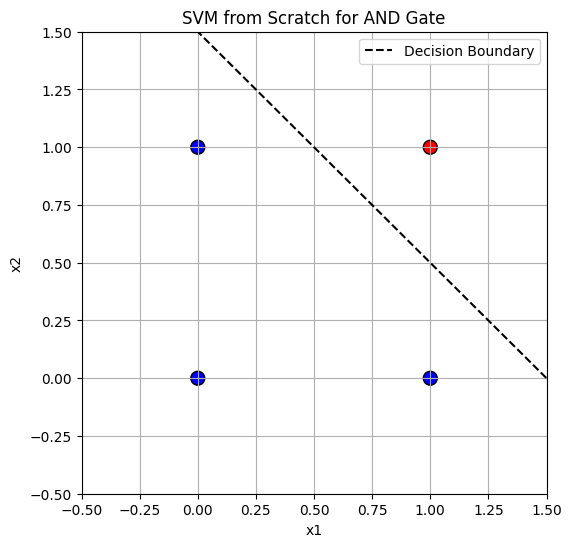

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=float)

y = np.array([-1, -1, -1, 1], dtype=float)  # Convert 0 -> -1

m, n = X.shape
K = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        K[i, j] = np.dot(X[i], X[j])

P = matrix(np.outer(y, y) * K)
q = matrix(-np.ones(m))
G = matrix(-np.eye(m))  # α_i ≥ 0
h = matrix(np.zeros(m))
A = matrix(y, (1, m))
b = matrix(0.0)

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x']).flatten()

w = np.sum((alphas * y)[:, None] * X, axis=0)

sv = (alphas > 1e-5)
b = np.mean(y[sv] - np.dot(X[sv], w))

print("Weights:", w)
print("Bias:", b)

 
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=100, edgecolors='k')

x1 = np.linspace(-0.5, 1.5, 100)
x2 = -(w[0]*x1 + b)/w[1]
plt.plot(x1, x2, 'k--', label='Decision Boundary')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("SVM from Scratch for AND Gate")
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

q2

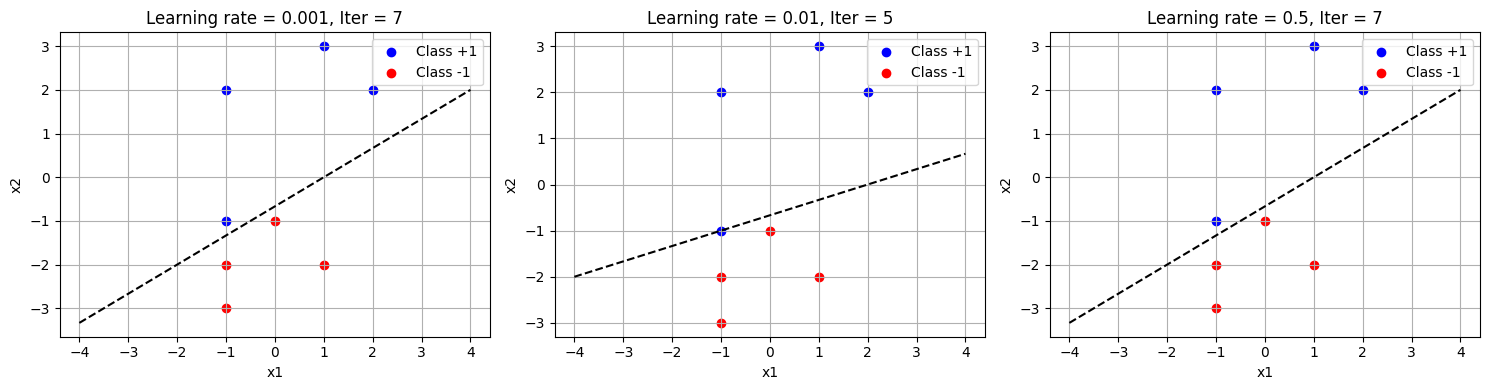

Learning Rate | Iterations to Converge
0.001          | 7
0.01           | 5
0.5            | 7


In [5]:
X = np.array([
    [2, 2],
    [-1, -3],
    [-1, 2],
    [0, -1],
    [1, 3],
    [-1, -2],
    [1, -2],
    [-1,-1]
])

y = np.array([1, 0, 1, 0, 1, 0, 0, 1])    
y = np.where(y == 0, -1, 1)            

def train_perceptron(X, y, lr=0.01, max_iter=10000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    for epoch in range(max_iter):
        error_count = 0
        for i in range(n_samples):
            activation = np.dot(X[i], w) + b
            if y[i] * activation <= 0:   # Misclassified
                w += lr * y[i] * X[i]
                b += lr * y[i]
                error_count += 1
        if error_count == 0:             # Converged
            break
    return w, b, epoch + 1

learning_rates = [0.001, 0.01, 0.5]
results = []

plt.figure(figsize=(15, 4))

for i, lr in enumerate(learning_rates, 1):
    w, b, iters = train_perceptron(X, y, lr)
    results.append((lr, iters))
     
    plt.subplot(1, 3, i)
    plt.title(f"Learning rate = {lr}, Iter = {iters}")
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class +1')
    plt.scatter(X[y==-1, 0], X[y==-1, 1], color='red', label='Class -1')
    
    # Decision boundary: w1*x1 + w2*x2 + b = 0  ->  x2 = -(w1*x1 + b)/w2
    x1_vals = np.linspace(-4, 4, 100)
    x2_vals = -(w[0]*x1_vals + b) / w[1]
    plt.plot(x1_vals, x2_vals, 'k--')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Learning Rate | Iterations to Converge")
for lr, iters in results:
    print(f"{lr:<14} | {iters}")

q3

In [6]:
from sklearn import datasets
 
iris = datasets.load_iris()
X = iris.data[:, [1, 2]]   
y = iris.target
class_names = iris.target_names

def train_svm(X, y, lr=0.01, epochs=1000, C=None):
    n_samples, n_features = X.shape
    y = y.astype(float)
    y[y == 0] = -1   

    alpha = np.zeros(n_samples)
   
    K = X @ X.T  # dot product

    for _ in range(epochs):
        for i in range(n_samples):
          
            grad = 1 - y[i] * np.sum(alpha * y * K[:, i])
            alpha[i] += lr * grad

            alpha[i] = max(0, alpha[i])

            if C is not None:
                alpha[i] = min(C, alpha[i])

    w = np.sum((alpha * y)[:, None] * X, axis=0)
    
    sv_idx = np.where((alpha > 1e-5) & (alpha < (C if C else 1e5)))[0]
    if len(sv_idx) > 0:
        b = np.mean(y[sv_idx] - X[sv_idx] @ w)
    else:
        b = 0

    return w, b, alpha

def plot_decision_boundary(X, y, w, b, class_names, i, j):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[y == -1, 0], X[y == -1, 1], label=class_names[i])
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label=class_names[j])

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                         np.linspace(ylim[0], ylim[1], 200))
    Z = w[0] * xx + w[1] * yy + b

    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
               alpha=0.7, linestyles=['--', '-', '--'])

    plt.xlabel('Sepal Width (cm)')
    plt.ylabel('Petal Length (cm)')
    plt.title(f"SVM Decision Boundary: {class_names[i]} vs {class_names[j]}")
    plt.legend()
    plt.show()

pairs = [(0, 1), (1, 2), (0, 2)]

for (i, j) in pairs:
    idx = np.where((y == i) | (y == j))
    X_pair = X[idx]
    y_pair = y[idx]

    # Map to -1 and +1
    y_binary = np.where(y_pair == i, -1, 1)

    # Train custom SVM
    w, b, alpha = train_svm(X_pair, y_binary, lr=0.01, epochs=3000, C=1)

    # Plot
    plot_decision_boundary(X_pair, y_binary, w, b, class_names, i, j)

ModuleNotFoundError: No module named 'sklearn'